# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerPatch

from FOMCDataPrep import DataPrep
from sklearn.decomposition import PCA

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

In [3]:
def prep_yields() -> pd.DataFrame: 

    df_yield = (DataPrep().get_tsy_yields().reset_index().rename(
        columns = {"DATE": "Date"}).
        assign(Date = lambda x: pd.to_datetime(x.Date).dt.date).
        melt(id_vars = "Date").
        dropna())
    
    return df_yield

df_yield = prep_yields()

Searching for Treasury data
Found Data


In [4]:
def get_yield_window(before = -1, after = 1) -> pd.DataFrame:
    
    df_dates = BBGCollect()._get_days_window(ticker = "FDTR", before = before, after = after)

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row
        df_tmp = df_yield.query("@start_date <= Date <= @end_date")
        
        df_combined = (pd.concat(
            [df_combined, df_tmp]).
            groupby(["Date", "variable"]).
            head(1))
        
    return df_combined

df_yield_window = get_yield_window()
df_ex_before = get_yield_window(before = 0, after = 1)

In [5]:
def get_window_yield(df_yield: pd.DataFrame, df_yield_window: pd.DataFrame, df_ex_before: pd.DataFrame) -> pd.DataFrame: 

    df_out = pd.DataFrame()
    tsys = df_yield_window.variable.drop_duplicates().to_list()

    for tsy in tsys:
        
        df_yield_tmp = df_yield.query("variable == @tsy")

        df_yield_window_tmp = (df_yield_window.query(
            "variable == @tsy").
            rename(columns = {"value": "window"}))

        start_date = df_yield_window_tmp.Date.min()
        start_yield = df_yield_tmp.query("Date == @start_date").value.iloc[0]

        df_tmp = (df_yield_tmp.query(
            "Date >= @start_date").
            merge(right = df_yield_window_tmp, how = "outer", on = ["Date", "variable"]).
            sort_values("Date").
            assign(
                yield_change = lambda x: x.value.diff(),
                window_change = lambda x: np.where(x.window == x.window, x.yield_change, 0),
                cum_window_change = lambda x: x.window_change.cumsum(),
                test = lambda x: start_yield + x.cum_window_change)
            [["Date", "variable", "value", "test"]].
            rename(columns = {
                "value": "raw_yield",
                "test": "three_day"}).
            merge(right = df_ex_before, how = "left", on = ["Date", "variable"]).
            assign(
                yield_change = lambda x: x.raw_yield.diff(),
                window_change = lambda x: np.where(x.value == x.value, x.yield_change, 0),
                cum_window_change = lambda x: x.window_change.cumsum(),
                test = lambda x: start_yield + x.cum_window_change)
            [["Date", "variable", "raw_yield", "three_day", "test"]].
            rename(columns = {"test": "ex_pre"}))

        df_out = pd.concat([df_out, df_tmp])
        
    return df_out    
    
df_hypothetical_yield = get_window_yield(df_yield, df_yield_window, df_ex_before)

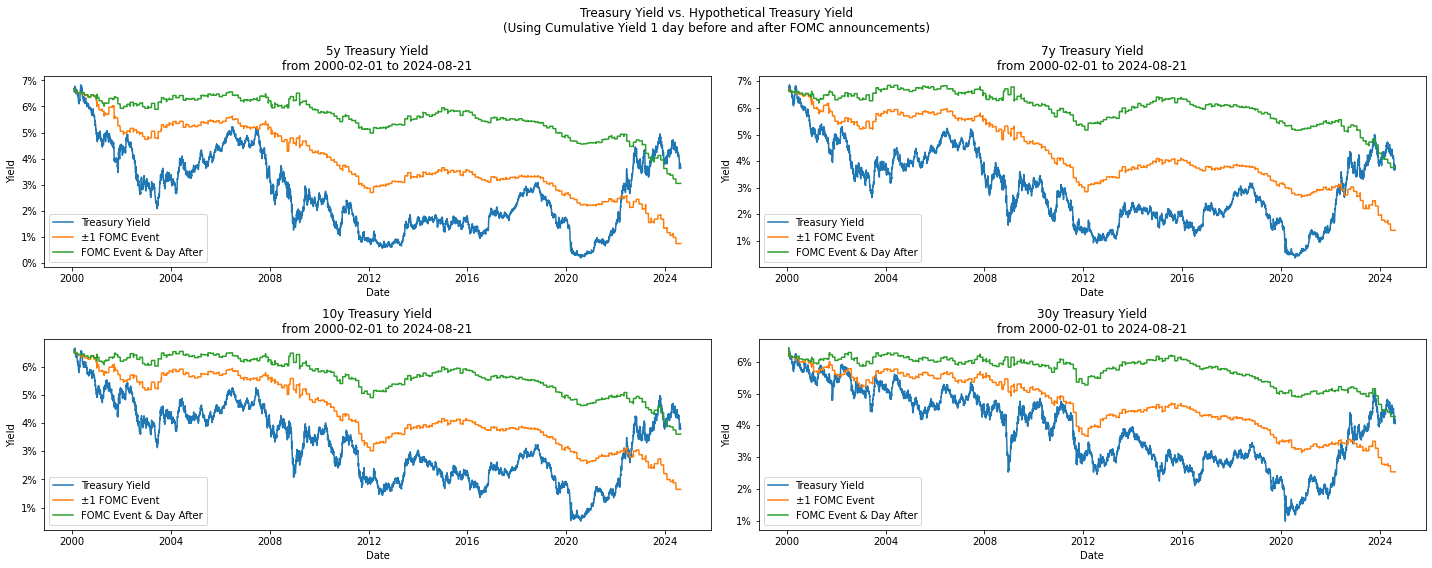

In [6]:
def plot_hypothetical_yield(df_hypothetical_yield: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y"}
    
    col_renamer = {
        "raw_yield": "Treasury Yield",
        "three_day": "±1 FOMC Event",
        "ex_pre": "FOMC Event & Day After"}

    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20,8))

    for ticker, ax in zip(renamer.keys(), axes.flatten()):

        df_tmp = (df_hypothetical_yield.query(
            "variable == @ticker").
            rename(columns = {
                "test": "FOMC",
                "value": "yield"}).
            drop(columns = ["variable"]).
            set_index("Date").
            rename(columns = col_renamer))

        (df_tmp.plot(
            ax = ax,
            ylabel = "Yield",
            title = renamer[ticker] + " Treasury Yield\nfrom {} to {}".format(
                df_tmp.index.min(),
                df_tmp.index.max())))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))


    fig.suptitle("Treasury Yield vs. Hypothetical Treasury Yield\n(Using Cumulative Yield 1 day before and after FOMC announcements)")
    plt.tight_layout()
    
plot_hypothetical_yield(df_hypothetical_yield)

In [7]:
def _get_order(df: pd.DataFrame, before: float, after: float) -> pd.DataFrame: 
    
    try: 
    
        df_out = (df.sort_values(
            "Date").
            assign(order = [i for i in range(before, after + 1)]))
        
        return df_out
    
    except:  pass

def get_window_ordered(before: int = -1, after: int = 1) -> pd.DataFrame: 
    
    df_dates = BBGCollect()._get_days_window(ticker = "FDTR", before = before, after = after)

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row
        df_tmp = (df_yield.query(
            "@start_date <= Date <= @end_date").
            groupby("variable").
            apply(_get_order, before, after).
            reset_index(drop = True))

        df_combined = (pd.concat(
            [df_combined, df_tmp]).
            groupby(["Date", "variable"]).
            head(1))

    return df_combined

df_window_ordered = get_window_ordered()

In [8]:
def get_window_order_change(df_yield: pd.DataFrame, df_window_ordered: pd.DataFrame) -> pd.DataFrame: 
    
    df_yield_change = (df_yield.pivot(
        index = "Date", columns = "variable", values = "value").
        diff().
        reset_index().
        melt(id_vars = "Date").
        dropna())

    df_window_change = (df_window_ordered.drop(
        columns = ["value"]).
        merge(right = df_yield_change, how = "inner", on = ["Date", "variable"]))
    
    return df_window_change

df_window_change = get_window_order_change(df_yield, df_window_ordered)

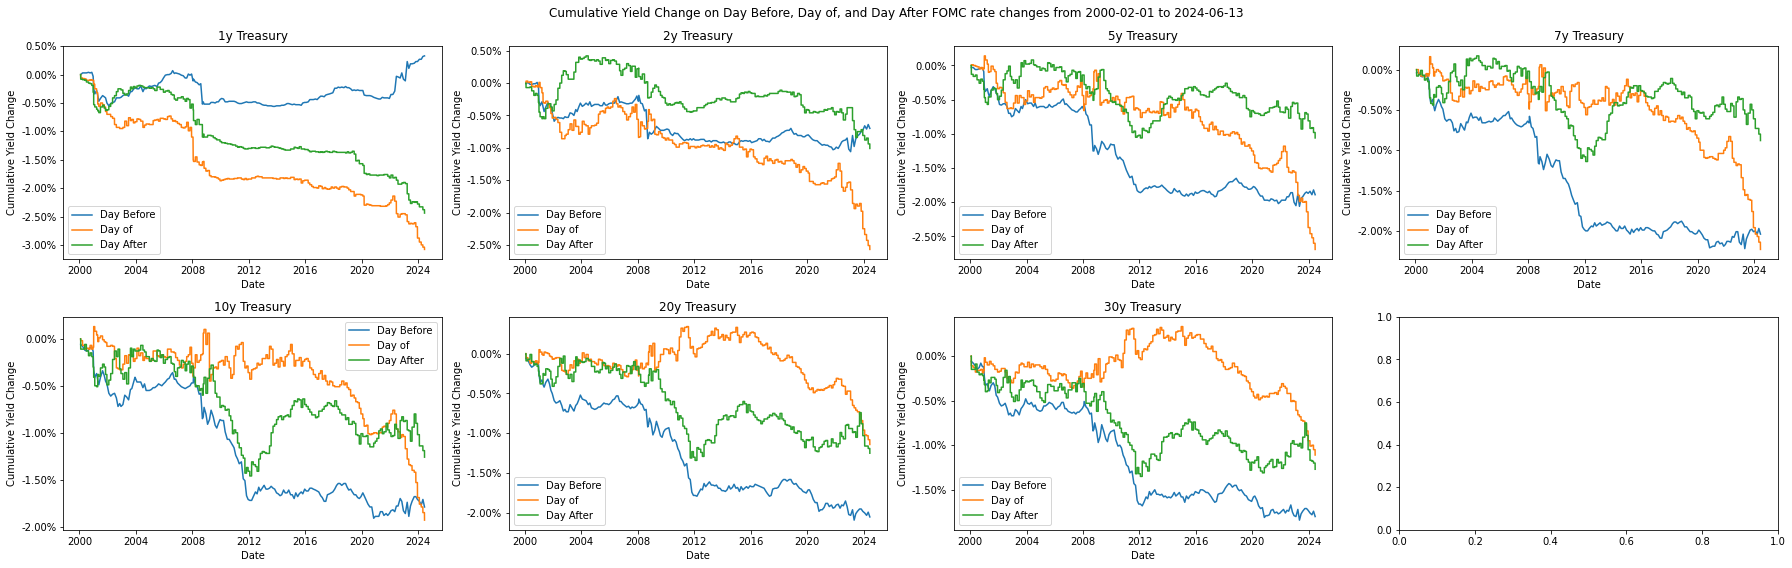

In [9]:
def plot_fomc_synthetic_yields(df_window_change: pd.DataFrame) -> plt.Figure: 
    
    treasury_dict = {
        "DGS1": "1y Treasury", 
        "DGS2": "2y Treasury", 
        "DGS5": "5y Treasury", 
        "DGS7": "7y Treasury", 
        "DGS10": "10y Treasury", 
        "DGS20": "20y Treasury", 
        "DGS30": "30y Treasury"}

    renamer = {
        -1: "Day Before",
        0: "Day of",
        1: "Day After"}

    fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (25,8))
    for variable, ax in zip(treasury_dict.keys(), axes.flatten()):

        (df_window_change.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            pivot(index = "Date", columns = "order", values = "value").
            fillna(0).
            rename(columns = renamer).
            cumsum().
            plot(
                ax = ax,
                title = treasury_dict[variable],
                ylabel = "Cumulative Yield Change"))

        ax.legend(title = "")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}%'))

    fig.suptitle("Cumulative Yield Change on Day Before, Day of, and Day After FOMC rate changes from {} to {}".format(
        df_window_change.Date.min(),
        df_window_change.Date.max()))
    plt.tight_layout()
    
plot_fomc_synthetic_yields(df_window_change)

In [10]:
def get_ordered_changes(df_yield: pd.DataFrame, begin: float = -6, end: float = 1) -> pd.DataFrame: 

    df_ordered = (df_yield.pivot(
        index = "Date", columns = "variable", values = "value").
        diff().
        reset_index().
        melt(id_vars = "Date").
        rename(columns = {"value": "yield_diff"}).
        merge(
            right = get_window_ordered(before = begin, after = end), 
            how = "inner", 
            on = ["Date", "variable"]).
        drop(columns = ["value"]).
        rename(columns = {"yield_diff": "value"}))
    
    return df_ordered

df_ordered = get_ordered_changes(df_yield)

In [11]:
def _get_pc_importance(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.drop(
        columns = ["order"]).
        pivot(index = "Date", columns = "variable", values = "value").
        diff().
        dropna())
    
    exp_variance = PCA(n_components = 3).fit(df_tmp).explained_variance_ratio_
    
    df_out = (pd.DataFrame().assign(
        PC = [i + 1 for i in range(len(exp_variance))],
        exp_variance = exp_variance))
    
    return df_out

def get_pc_importance(df_ordered: pd.DataFrame) -> pd.DataFrame: 

    df_pc = (df_ordered.groupby(
        "order").
        apply(_get_pc_importance).
        reset_index().
        drop(columns = ["level_1"]).
        pivot(index = "order", columns = "PC", values = "exp_variance"))
    
    return df_pc

df_pc = get_pc_importance(df_ordered)

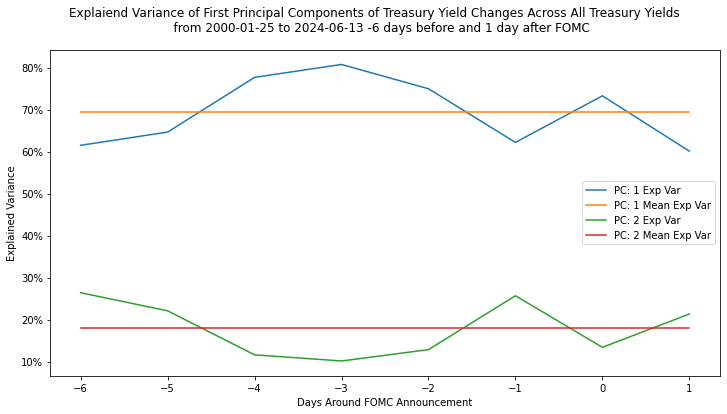

In [20]:
def plot_explained_variance(
    df_pc: pd.DataFrame, 
    df_ordered: pd.DataFrame, 
    pcs: list = [1,2]) -> plt.Figure:
    
    df_longer = (df_pc.drop(
        columns = [3]).
        reset_index().
        melt(id_vars = "order"))

    df_plot = (df_longer.drop(
        columns = ["order"]).
        groupby("PC").
        agg("mean").
        rename(columns = {"value": "mean_exp"}).
        merge(right = df_longer, how = "inner", on = ["PC"]))

    fig, axes = plt.subplots(figsize = (12,6))
    for pc in pcs: 

        df_tmp = (df_plot.query(
            "PC == @pc").
            drop(columns = ["PC"]).
            rename(columns = {"value": "exp_var"}).
            melt(id_vars = "order").
            assign(variable = lambda x: np.where(
                x.variable == "mean_exp", 
                "PC: " + str(pc) + " Mean Exp Var", 
                "PC: " + str(pc) + " Exp Var")).
            pivot(index = "order", columns = "variable", values = "value"))

        df_tmp.plot(
            ax = axes,
            ylabel = "Explained Variance",
            xlabel = "Days Around FOMC Announcement")

    axes.legend(title = "")
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle('''Explaiend Variance of First Principal Components of Treasury Yield Changes Across All Treasury Yields
    from {} to {} -6 days before and 1 day after FOMC'''.format(
        df_ordered.Date.min(),
        df_ordered.Date.max()))
    
plot_explained_variance(df_pc, df_ordered)